In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### Data Preprocessing

In [ ]:
calm = pd.read_csv("/content/S01G2AllRawChannels.csv")
horror =  pd.read_csv("/content/S01G3AllRawChannels.csv")

# TODO: adjust if needed
sampling_rate = 133 # (Hz)

In [ ]:
calm.columns

Index(['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7',
       'P8', 'T7', 'T8', 'Unnamed: 14'],
      dtype='object')

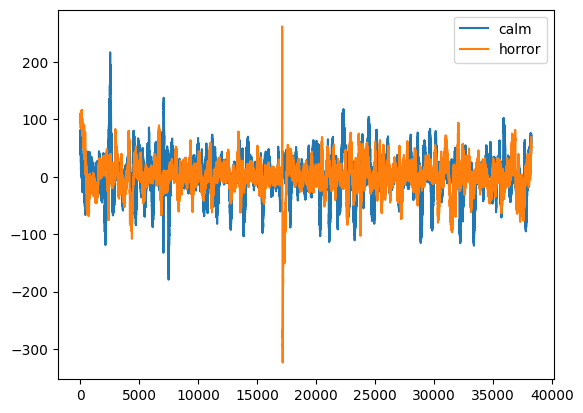

In [ ]:
# TODO: choose one of the frontal electrodes (F3 / F4 / F7 / F8 / FC5 / FC6)
# and check that it is clean
electrode = "F3"
plt.plot(calm[electrode], label = "calm")
plt.plot(horror[electrode], label = "horror")
plt.legend()

In [ ]:
# TODO: re-reference data if needed
# ...

# Traces for splitting into clips
calm = calm[electrode].to_numpy()
horror = horror[electrode].to_numpy()

In [ ]:
# TODO: adjust if needed
clip_length = 0.5 # (seconds)

# Split into clips
calm_clips = np.array_split(calm, len(calm) // (clip_length * sampling_rate))
horror_clips = np.array_split(horror, len(horror) // (clip_length * sampling_rate))

In [ ]:
# Construct X and y
X = []
y = []

min_len_calm = np.min([len(arr) for arr in calm_clips])
min_len_horror = np.min([len(arr) for arr in horror_clips])
min_len = np.min([min_len_calm, min_len_horror])

for array in calm_clips:
    X.append(array[:min_len])
    y.append(0)

for array in horror_clips:
    X.append(array[:min_len])
    y.append(1)

X = np.vstack(X)
y = np.array(y)

#### ML Model

In [ ]:
np.random.seed(123)

# Add an additional axis required by torch's Conv layers
X = np.expand_dims(X, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Convert to torch tensors
X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

In [ ]:
X_train.shape

torch.Size([805, 1, 66])

In [ ]:
class LFPDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# Batch generators

# TODO: adjust if needed
batch_size = 32

train_batch_generator = torch.utils.data.DataLoader(LFPDataset(X_train, y_train), batch_size = batch_size,
                                                    shuffle = True)

test_batch_generator = torch.utils.data.DataLoader(LFPDataset(X_test, y_test), batch_size = batch_size,
                                                    shuffle = False)

In [ ]:
# TODO: adjust if needed
model = torch.nn.Sequential(
    torch.nn.Conv1d(1, 1, kernel_size = 10, padding = "same"),
    torch.nn.Flatten(),
    torch.nn.Linear(66, 1)
)

In [ ]:
from sklearn.metrics import accuracy_score

def train(n_epoch, model):
    # TODO: adjust learning rate if needed
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    for e in range(n_epoch):
        model.train(True)

        train_loss = []
        train_acc = []
        for X_batch, y_batch in train_batch_generator:
            model.zero_grad()
            logits = model(X_batch).squeeze()
            loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_batch)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().numpy())
            train_acc.append(accuracy_score(y_batch.detach().numpy(), torch.sigmoid(logits).detach().numpy() > 0.5))

        model.train(False)
        test_loss = []
        test_acc = []
        with torch.no_grad():
            for X_batch, y_batch in test_batch_generator:
                logits = model(X_batch).squeeze()
                loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_batch)
                test_loss.append(loss.detach().numpy())
                test_acc.append(accuracy_score(y_batch.detach().numpy(), torch.sigmoid(logits).detach().numpy() > 0.5))

        print(f"Epoch {e} : train_loss={np.mean(train_loss)}, train_acc={np.mean(train_acc)}, test_loss={np.mean(test_loss)}, test_acc={np.mean(test_acc)}")

    return model

In [ ]:
train(20, model)

Epoch 0 : train_loss=1.119484305381775, train_acc=0.5002403846153846, test_loss=1.1098357439041138, test_acc=0.475
Epoch 1 : train_loss=0.9474302530288696, train_acc=0.5336538461538461, test_loss=0.9717029929161072, test_acc=0.4920454545454545
Epoch 2 : train_loss=0.8805294632911682, train_acc=0.5242788461538461, test_loss=0.8834880590438843, test_acc=0.4920454545454545
Epoch 3 : train_loss=0.8174842596054077, train_acc=0.5254807692307693, test_loss=0.8384090662002563, test_acc=0.49568181818181817
Epoch 4 : train_loss=0.7864622473716736, train_acc=0.5367788461538462, test_loss=0.8102550506591797, test_acc=0.5070454545454545
Epoch 5 : train_loss=0.760367751121521, train_acc=0.5435096153846154, test_loss=0.7735353708267212, test_acc=0.524090909090909
Epoch 6 : train_loss=0.7407475709915161, train_acc=0.5411057692307693, test_loss=0.7661120891571045, test_acc=0.5171590909090908
Epoch 7 : train_loss=0.726760983467102, train_acc=0.5377403846153845, test_loss=0.7484865188598633, test_acc=0.5

Sequential(
  (0): Conv1d(1, 1, kernel_size=(10,), stride=(1,), padding=same)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=66, out_features=1, bias=True)
)